# Data Processing Pipeline for BM (mESC1) Dataset

This notebook integrates a series of Python scripts to process single-cell data for the mESC1 dataset, which is the focus for the 'BM' project. The pipeline is designed to be run sequentially from top to bottom and covers the following major steps:

1.  **Gene Regulatory Network (GRN) Inference:** Uses `celloracle` to infer GRNs for each individual timepoint.
2.  **Link Aggregation:** Combines the GRN links from all timepoints into a single, comprehensive CSV file.
3.  **Link Processing:** Cleans the aggregated links file and maps gene names to standardized integer IDs.
4.  **Node Feature Extraction:** Generates a feature matrix based on gene expression profiles for all genes (nodes) across all timepoints.
5.  **ML Input Generation:** Converts the processed links and features into the final format required for machine learning models (`.csv` for graph edges and `.npy` for edge features).
6.  **Experimental Variations:** Includes additional steps for sub-sampling the gene set and generating corresponding ML input files and job submission scripts for different experimental conditions.

## 1. Configuration and Setup

**Purpose:** This cell centralizes all library imports, path definitions, and key parameters for the entire pipeline.

**Why:** Centralizing configuration makes the notebook easier to manage, modify, and adapt for different datasets or environments. All file paths and important variables are defined here, ensuring consistency throughout the workflow.

**Input:** The required h5ad-related data files can be obtained through the **data_preparation.ipynb** file. Download links for celloracle-related files:<https://github.com/morris-lab/CellOracle>.

**Output:** A ready-to-use Python environment with all necessary libraries and configuration variables.

In [ ]:
# === Core Library Imports ===
import os
import re
import pickle
import shutil

# === Data Science and Bioinformatics Libraries ===
import anndata as ad
import pandas as pd
import numpy as np
import scanpy as sc
import celloracle as co
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder

# === General Parameters ===
# Dataset name, used for file naming and path construction.
DATASET_NAME = "mESC1" 
# List of timepoints to be processed. Inferred from the original scripts.
#TIMEPOINTS = list(range(9))
TIMEPOINTS = [8]

# === Final Output Path Configuration ===
# Main directory to save all final results from this notebook, as requested.
FINAL_OUTPUT_DIR = f"./result/{DATASET_NAME}/"

# === Subdirectory Creation for Organized Output ===
ORACLE_OUTPUT_DIR = os.path.join(FINAL_OUTPUT_DIR, "oracle_outputs")
PROCESSED_DATA_DIR = os.path.join(FINAL_OUTPUT_DIR, "processed_data")
ML_INPUT_DIR = os.path.join(FINAL_OUTPUT_DIR, "ml_inputs")
FIGURES_DIR = os.path.join(FINAL_OUTPUT_DIR, "figures")
SUBMISSION_SCRIPTS_DIR = os.path.join(FINAL_OUTPUT_DIR, "submission_scripts")

# Create all output directories if they don't already exist.
for path in [ORACLE_OUTPUT_DIR, PROCESSED_DATA_DIR, ML_INPUT_DIR, FIGURES_DIR, SUBMISSION_SCRIPTS_DIR]:
    os.makedirs(path, exist_ok=True)

# === Input File Paths (Dynamically constructed) ===
RAW_DATA_BASE_DIR = f".data/{DATASET_NAME}/"
GENE_MAPPING_FILE = f"./data/{DATASET_NAME}/gene_mapping.csv"
FULL_ADATA_FILE = f"./data/{DATASET_NAME}/{DATASET_NAME}.h5ad"
GRN_DEFINITION_FILE = "./data/celloracle/data/promoter_base_GRN/mm10_TFinfo_dataframe_gimmemotifsv5_fpr2_threshold_10_20210630.parquet"

# === Processed File Paths (Dynamically constructed) ===
AGGREGATED_LINKS_CSV = os.path.join(PROCESSED_DATA_DIR, f"{DATASET_NAME}_all_links.csv")
PROCESSED_LINKS_CSV = os.path.join(PROCESSED_DATA_DIR, f"processed_{DATASET_NAME}_all_links.csv")
NODE_FEATURES_PKL = os.path.join(PROCESSED_DATA_DIR, f"{DATASET_NAME}_1000_node_features.pkl")
ML_LINKS_CSV = os.path.join(ML_INPUT_DIR, f"ml_{DATASET_NAME}.csv")
ML_EDGE_FEATURES_NPY = os.path.join(ML_INPUT_DIR, f"ml_{DATASET_NAME}.npy")

print(f"✅ Configuration complete. ")

✅ Configuration complete. 


## 2. Per-Timepoint GRN Inference with CellOracle

**Purpose:** This section iterates through each timepoint. For each one, it loads the corresponding `.h5ad` data, preprocesses it, and uses `celloracle` to infer a Gene Regulatory Network (GRN).

**Why:** Inferring GRNs at each timepoint separately allows us to capture the dynamic regulatory changes that occur over time. This is the first major computational step in the pipeline.

**Input:** 
- A series of `.h5ad` files, one for each timepoint (e.g., `ST_t0.h5ad`, `ST_t1.h5ad`, etc.).
- A GRN definition file (`.parquet`) containing transcription factor information.

**Output:** 
- For each timepoint, several files are generated in the `oracle_outputs` directory:
  - `*.celloracle.oracle`: The celloracle object with imputed data.
  - `*.celloracle.links`: The inferred GRN connections.
  - `*_filter.celloracle.links`: The filtered GRN connections.
- Quality-control plots are saved to the `figures` directory.

Processing Timepoints with CellOracle:   0%|          | 0/1 [00:00<?, ?it/s]


--- Starting processing for stage: ST_t8 ---
📥 Loading h5ad for ST_t8
🔍 Filtering for top 3000 expressed genes
⚙️ Initializing and building Oracle object


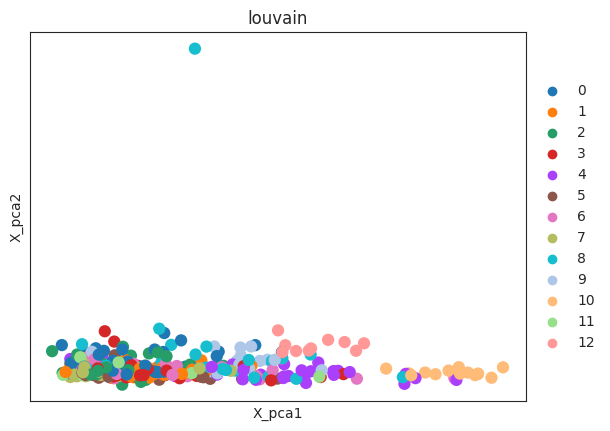

📥 Loading base GRN data
🤖 Performing KNN imputation with n_comps=50
🔗 Constructing regulatory network links


  0%|          | 0/13 [00:00<?, ?it/s]

Inferring GRN for 0...


  0%|          | 0/2852 [00:00<?, ?it/s]

Inferring GRN for 1...


  0%|          | 0/2852 [00:00<?, ?it/s]

Inferring GRN for 10...


  0%|          | 0/2852 [00:00<?, ?it/s]

Inferring GRN for 11...


  0%|          | 0/2852 [00:00<?, ?it/s]

Inferring GRN for 12...


  0%|          | 0/2852 [00:00<?, ?it/s]

Inferring GRN for 2...


  0%|          | 0/2852 [00:00<?, ?it/s]

Inferring GRN for 3...


  0%|          | 0/2852 [00:00<?, ?it/s]

Inferring GRN for 4...


  0%|          | 0/2852 [00:00<?, ?it/s]

Inferring GRN for 5...


  0%|          | 0/2852 [00:00<?, ?it/s]

Inferring GRN for 6...


  0%|          | 0/2852 [00:00<?, ?it/s]

Inferring GRN for 7...


  0%|          | 0/2852 [00:00<?, ?it/s]

Inferring GRN for 8...


  0%|          | 0/2852 [00:00<?, ?it/s]

Inferring GRN for 9...


  0%|          | 0/2852 [00:00<?, ?it/s]

🧹 Filtering links with p-value < 0.001
0


<Figure size 640x480 with 0 Axes>

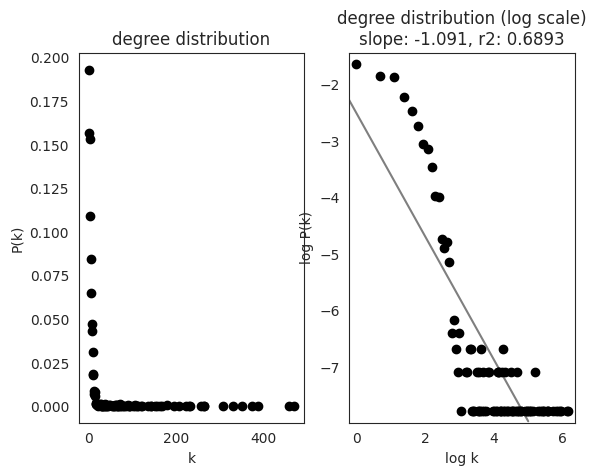

1


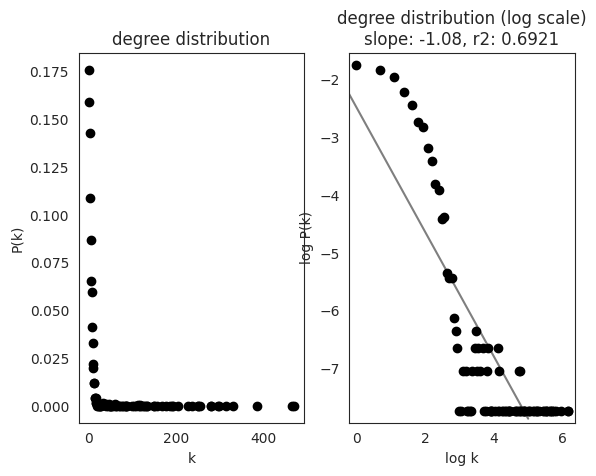

10


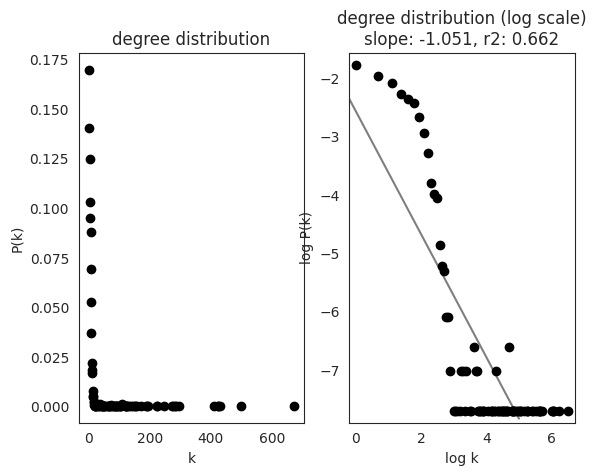

11


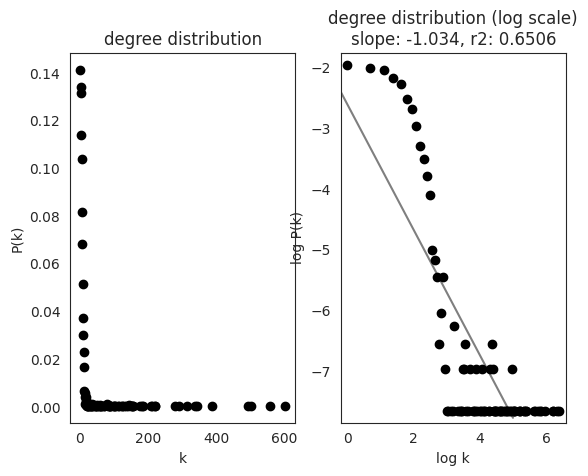

12


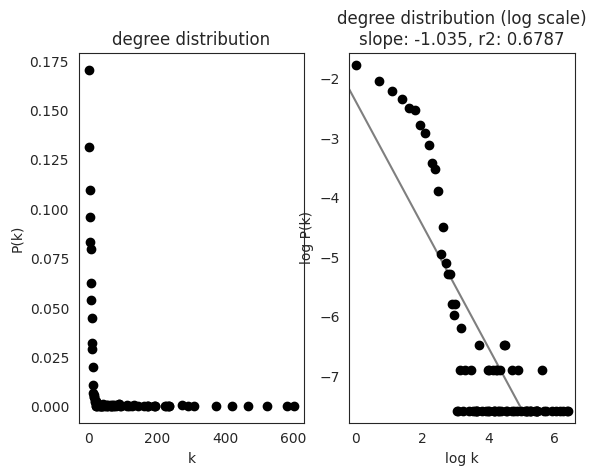

2


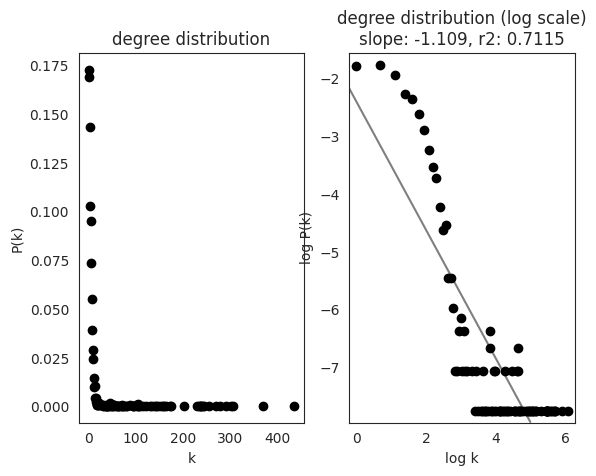

3


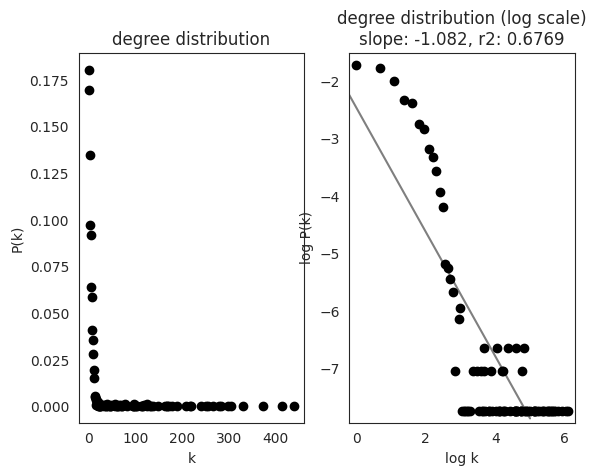

4


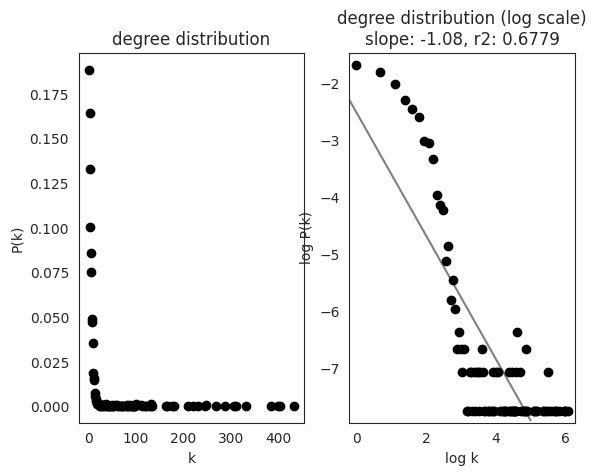

5


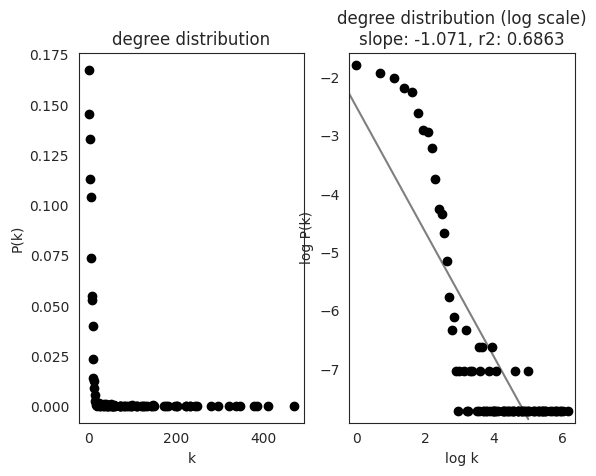

6


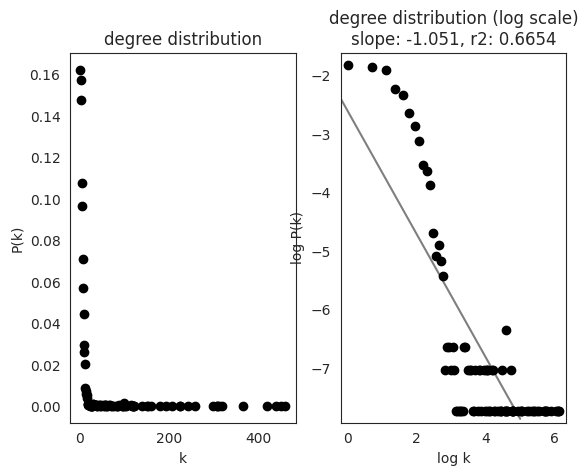

7


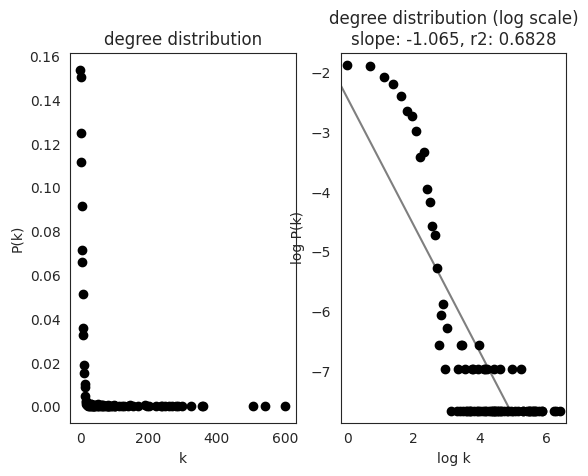

8


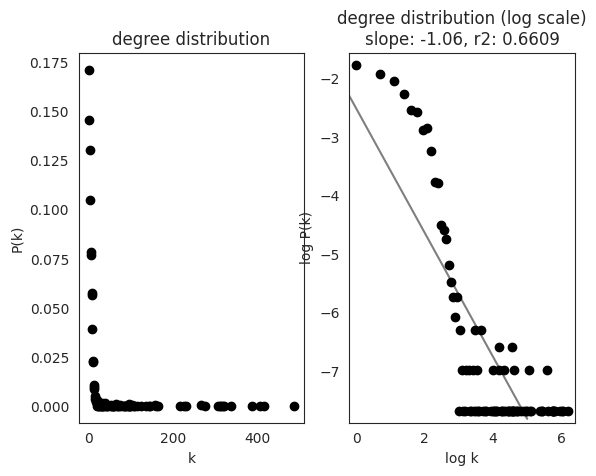

9


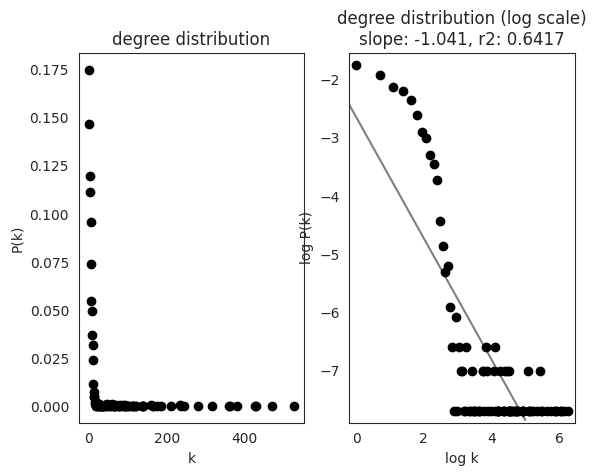

✅ ST_t8 processing complete. Outputs has been saved to the oracle_outputs folder.


🎉 All timepoints have been processed.


In [16]:
# This loop processes each timepoint individually using the logic from Pre_Oracle_BM.py
for timepoint in tqdm(TIMEPOINTS, desc="Processing Timepoints with CellOracle"):
    stage_id = f"ST_t{timepoint}"
    print(f"\n--- Starting processing for stage: {stage_id} ---")

    # --- Define input and output files for the current stage ---
    adata_file = os.path.join(RAW_DATA_BASE_DIR, f"{stage_id}.h5ad")
    oracle_file = os.path.join(ORACLE_OUTPUT_DIR, f"{stage_id}.celloracle.oracle")
    links_file = os.path.join(ORACLE_OUTPUT_DIR, f"{stage_id}.celloracle.links")
    filtered_links_file = os.path.join(ORACLE_OUTPUT_DIR, f"{stage_id}_filter.celloracle.links")

    # Check if the input file exists before proceeding
    if not os.path.exists(adata_file):
        print(f"⚠️ Warning: Input file not found for {stage_id}. Skipping. Path: {adata_file}")
        continue

    # --- Load and preprocess AnnData object ---
    print(f"📥 Loading h5ad for {stage_id}")
    adata = sc.read_h5ad(adata_file)
    adata.X = np.nan_to_num(adata.X) # Replace NaNs with zeros
    adata.layers["raw_count"] = adata.X.copy()
    adata.layers["normalized_count"] = adata.X.copy()

    # --- Select top 3000 highly expressed genes ---
    print("🔍 Filtering for top 3000 expressed genes")
    gene_total_expr = np.asarray(adata.X.sum(axis=0)).ravel()
    top_idx = np.argsort(gene_total_expr)[-3000:]
    adata = adata[:, adata.var_names[top_idx]].copy()

    # --- Dimensionality reduction and clustering ---
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)
    sc.tl.diffmap(adata, random_state=42)
    sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_diffmap')
    sc.tl.louvain(adata, resolution=0.8)

    # --- Initialize and build CellOracle object ---
    print("⚙️ Initializing and building Oracle object")
    oracle = co.Oracle()
    oracle.import_anndata_as_sctransform(adata=adata, cluster_column_name="louvain", embedding_name="X_pca")
    
    print("📥 Loading base GRN data")
    base_GRN = pd.read_parquet(GRN_DEFINITION_FILE)
    oracle.import_TF_data(TF_info_matrix=base_GRN)

    # --- Perform PCA and select number of components ---
    oracle.perform_PCA()
    explained = np.cumsum(oracle.pca.explained_variance_ratio_)
    n_comps = np.where(np.diff(np.diff(explained) > 0.002))[0][0]
    n_comps = min(n_comps, 50) # Cap at 50 components
    
    # --- KNN Imputation for data smoothing ---
    print(f"🤖 Performing KNN imputation with n_comps={n_comps}")
    k = int(0.025 * oracle.adata.shape[0])
    oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8, b_maxl=k*4, n_jobs=4)
    oracle.to_hdf5(oracle_file)

    # --- Construct and filter GRN links ---
    print("🔗 Constructing regulatory network links")
    links = oracle.get_links(cluster_name_for_GRN_unit="louvain", alpha=10, verbose_level=10)
    links.to_hdf5(links_file)

    print("🧹 Filtering links with p-value < 0.001")
    links.filter_links(p=0.001, weight="coef_abs")
    links.to_hdf5(filtered_links_file)
    
    # --- Save QC plots ---
    plt.figure()
    links.plot_degree_distributions(plot_model=True)
    plt.savefig(os.path.join(FIGURES_DIR, f"{stage_id}_degree_distribution.pdf"))
    plt.close()
    
    print(f"✅ {stage_id} processing complete. Outputs has been saved to the oracle_outputs folder.")

print("\n\n🎉 All timepoints have been processed.")

## 3. Aggregate GRN Links from All Timepoints

**Purpose:** This cell scans the `oracle_outputs` directory for all the `.celloracle.links` files generated in the previous step. It loads each file, extracts the regulatory links, adds timepoint information, and concatenates them into a single CSV file.

**Why:** Consolidating all links into one file is essential for analyzing the entire dynamic network and preparing the data for downstream machine learning tasks.

**Input:** A series of `.celloracle.links` files in the `oracle_outputs` directory.

**Output:** A single CSV file named `mESC1_all_links.csv` in the `processed_data` directory.

In [17]:
# This section incorporates the logic from links2csv_BM.py

# Remove the old aggregated file if it exists to ensure a fresh start.
if os.path.exists(AGGREGATED_LINKS_CSV):
    os.remove(AGGREGATED_LINKS_CSV)
    #print(f"Removed existing file: {AGGREGATED_LINKS_CSV}")

# Initialize an empty list to store DataFrames from each file.
all_links_dfs = []

print(f"Scanning for link files")
# Iterate through all files in the oracle output directory.
for file_name in tqdm(sorted(os.listdir(ORACLE_OUTPUT_DIR)), desc="Aggregating Links"):
    # Process only the unfiltered link files.
    if file_name.endswith(".celloracle.links") and "_filter" not in file_name:
        # Extract the timepoint number from the filename (e.g., 'ST_t1' -> 1).
        match = re.search(r'ST_t(\d+)', file_name)
        if not match:
            continue
        timepoint = int(match.group(1))
        file_path = os.path.join(ORACLE_OUTPUT_DIR, file_name)

        # Load the links object from the HDF5 file.
        links = co.load_hdf5(file_path=file_path)

        # Iterate through all cell types within the links object.
        for celltype, df in links.links_dict.items():
            if df is None or df.empty:
                continue

            df_processed = df.copy()
            # Insert Timepoint and Celltype information.
            df_processed.insert(0, "Timepoint", timepoint)
            df_processed.insert(1, "Celltype", celltype)

            # Filter for significant links (p-value < 0.001).
            df_processed = df_processed[df_processed["p"].notna() & (df_processed["p"] < 0.001)]
            
            # Sort by absolute coefficient and keep the top 5000 links per celltype.
            df_processed = df_processed.sort_values("coef_abs", ascending=False).head(5000)
            all_links_dfs.append(df_processed)

# Concatenate all DataFrames into a single one.
if all_links_dfs:
    final_df = pd.concat(all_links_dfs, ignore_index=True)
    final_df.to_csv(AGGREGATED_LINKS_CSV, index=False)
    print(f"\n✅ Aggregated links file has been saved to processed_data folder.")
    print(f"🔢 Total aggregated links: {len(final_df)}")

    # --- Verification Step ---
    print("\n🔍 Verification: Reading the first 5 rows of the created file.")
    display(final_df.head())
else:
    print("❌ Error: No link files were found or processed. The aggregated CSV was not created.")

Scanning for link files


Aggregating Links:   0%|          | 0/3 [00:00<?, ?it/s]


✅ Aggregated links file has been saved to processed_data folder.
🔢 Total aggregated links: 65000

🔍 Verification: Reading the first 5 rows of the created file.


,Timepoint,Celltype,source,target,coef_mean,coef_abs,p,-logp
0,8,0,Atf3,Slc25a24,1.550725,1.550725,1.847619e-12,11.733388
1,8,0,Sox7,Cd36,1.345114,1.345114,8.271237e-08,7.082430
2,8,0,Tead1,0610040F04Rik,1.124421,1.124421,1.851055e-15,14.732581
3,8,0,Atf3,Tm4sf4,1.121795,1.121795,1.269458e-07,6.896381
4,8,0,Mafg,Foxa2,1.050191,1.050191,7.421958e-10,9.129482


## 4. Process Aggregated Links (Gene ID Mapping)

**Purpose:** This cell takes the aggregated links CSV, maps the gene names in the 'source' and 'target' columns to their corresponding integer IDs using a gene mapping file, and cleans up the DataFrame.

**Why:** Machine learning models typically work with numerical IDs rather than string-based gene names. This step standardizes the input and ensures compatibility with graph-based models.

**Input:**
- `mESC1_all_links.csv`: The aggregated links file from the previous step.
- `gene_mapping.csv`: A file mapping gene names to integer IDs.

**Output:**
- `processed_mESC1_all_links.csv`: A new CSV file in the `processed_data` directory with gene names replaced by IDs.

In [19]:
# This section incorporates logic from the process_BM.ipynb notebook

print(f"📥 Reading gene mapping ")
gene_mapping_df = pd.read_csv(GENE_MAPPING_FILE)
gene_id_dict = dict(zip(gene_mapping_df['Gene'], gene_mapping_df['ID']))

print(f"📥 Reading aggregated links ")
df_links = pd.read_csv(AGGREGATED_LINKS_CSV)

# Add '-logp' column for feature engineering, handling p=0 cases.
if '-logp' not in df_links.columns:
    df_links['-logp'] = -np.log10(df_links['p'].replace(0, 1e-300))

print("🔄 Mapping gene names to IDs for 'source' and 'target' columns...")
df_links['source'] = df_links['source'].map(gene_id_dict)
df_links['target'] = df_links['target'].map(gene_id_dict)

# Drop rows where either source or target could not be mapped to an ID.
original_rows = len(df_links)
df_links.dropna(subset=['source', 'target'], inplace=True)
print(f"🗑️ Dropped {original_rows - len(df_links)} rows with unmapped gene names.")

# Ensure correct data types for IDs and timepoints.
df_links['source'] = df_links['source'].astype(int)
df_links['target'] = df_links['target'].astype(int)
df_links['Timepoint'] = df_links['Timepoint'].astype(int)

# Rename 'Timepoint' to 'Timepoints' for consistency with downstream scripts.
df_links.rename(columns={'Timepoint': 'Timepoints'}, inplace=True)

# Reorder columns to a standard format and sort by timepoint.
final_columns = ['source', 'target', 'coef_mean', 'coef_abs', 'p', '-logp', 'Celltype', 'Timepoints']
df_processed = df_links[final_columns].sort_values(by=['Timepoints'])

# Save the fully processed file.
df_processed.to_csv(PROCESSED_LINKS_CSV, index=False)
print(f"✅ Processed links file has been saved")

# --- Verification Step ---
print("\n🔍 Verification: Displaying a sample of 5 rows from the processed file.")
display(df_processed.sample(5))

📥 Reading gene mapping 
📥 Reading aggregated links 
🔄 Mapping gene names to IDs for 'source' and 'target' columns...
🗑️ Dropped 0 rows with unmapped gene names.
✅ Processed links file has been saved

🔍 Verification: Displaying a sample of 5 rows from the processed file.


,source,target,coef_mean,coef_abs,p,-logp,Celltype,Timepoints
20639,17753,21452,0.091148,0.091148,2.013892e-09,8.695964,12,8
43499,5314,7242,0.133604,0.133604,6.037318e-08,7.219156,5,8
29712,7848,15963,0.127250,0.127250,2.227239e-06,5.652233,2,8
45291,20619,19674,0.374715,0.374715,4.283586e-08,7.368192,6,8
2573,13183,19646,0.181177,0.181177,2.152493e-06,5.667058,0,8


## 5. Extract and Process Node Features

**Purpose:** This cell loads the complete AnnData object for the dataset. It then processes this data to create a feature representation for each gene (node) at each timepoint.

**Why:** In dynamic graph models, nodes (genes) need features that describe their state at different times. Here, we use a sample of a gene's expression distribution across cells at a specific timepoint as its feature vector.

**Input:**
- `mESC1.h5ad`: The main AnnData file containing the full expression matrix.
- `gene_mapping.csv`: To map gene names to IDs.

**Output:**
- `mESC1_1000_node_features.pkl`: A pickle file containing a nested dictionary. The structure is `gene_ID -> timepoint -> [list of 1000 expression values]`.

In [22]:
# This section incorporates the logic from Get_Exp_BM.py

print(f"📥 Reading full AnnData ")
adata = ad.read_h5ad(FULL_ADATA_FILE)
print(f"📥 Reading gene mapping from: ")
gene_map_df = pd.read_csv(GENE_MAPPING_FILE)
gene_id_map = dict(zip(gene_map_df["Gene"], gene_map_df["ID"]))

print("🔬 Preparing expression matrix...")
# Ensure data is in a dense numpy array and replace NaNs.
adata.X = np.nan_to_num(adata.X.toarray() if not isinstance(adata.X, np.ndarray) else adata.X)

# Create a pandas DataFrame for easier indexing, KEEPING THE ORIGINAL GENE NAMES.
adata_df = pd.DataFrame(adata.X, index=adata.obs.index, columns=adata.var_names)

# Filter the DataFrame to only include genes that are in our mapping file.
valid_genes = [gene for gene in adata_df.columns if gene in gene_id_map]
adata_df = adata_df[valid_genes]

# Now, safely rename the DataFrame columns from gene names (strings) to gene IDs (integers).
adata_df.rename(columns=gene_id_map, inplace=True)

# Group cells by their timepoint from the observation metadata.
grouped = adata.obs.groupby("timepoint")

# This dictionary will store the final features: gene -> timepoint -> [expression_values]
all_gene_expr = defaultdict(dict)

# Process each timepoint.
for timepoint, group in tqdm(grouped, desc="Extracting Node Features"):
    cell_indices = group.index.tolist()
    if not cell_indices:
        continue

    # Get the expression sub-matrix for the current timepoint.
    cell_expr_subset = adata_df.loc[cell_indices]

    # For each gene, sample its expression values from the cells at this timepoint.
    # The gene_id here is now a valid integer ID from the renamed DataFrame columns.
    for gene_id in cell_expr_subset.columns:
        values = cell_expr_subset[gene_id].values
        # Sample 1000 values to form the feature vector.
        if len(values) >= 1000:
            selected_values = np.random.choice(values, 1000, replace=False)
        elif len(values) > 0:
            selected_values = np.random.choice(values, 1000, replace=True)
        else:
            selected_values = np.zeros(1000)
        all_gene_expr[gene_id][int(timepoint)] = selected_values.tolist()

# Save the generated features to a pickle file.
with open(NODE_FEATURES_PKL, 'wb') as f:
    pickle.dump(all_gene_expr, f)

print(f"\n✅ Node features have been saved to the processed_data folder.")

# --- Verification Step ---
print("\n🔍 Verification: Checking the structure of the generated feature dictionary.")
if all_gene_expr:
    first_gene = next(iter(all_gene_expr))
    first_timepoint = next(iter(all_gene_expr[first_gene]))
    feature_vector_length = len(all_gene_expr[first_gene][first_timepoint])
    print(f"  - Example Gene ID: {first_gene}")
    print(f"  - Example Timepoint: {first_timepoint}")
    print(f"  - Feature vector length: {feature_vector_length}")
else:
    print("  - No features were generated. The dictionary is empty.")

📥 Reading full AnnData 
📥 Reading gene mapping from: 
🔬 Preparing expression matrix...


Extracting Node Features:   0%|          | 0/9 [00:00<?, ?it/s]


✅ Node features have been saved to the processed_data folder.

🔍 Verification: Checking the structure of the generated feature dictionary.
  - Example Gene ID: 0
  - Example Timepoint: 0
  - Feature vector length: 1000


## 6. Generate Final Machine Learning Inputs

**Purpose:** This cell creates the final data files that will be directly consumed by the machine learning model. It generates two files: one describing the graph's edges and another containing the features for those edges.

**Why:** This standardizes the data into a clean, model-ready format. Separating the graph structure (edges) from the features is a common practice in graph machine learning.

**Input:**
- `processed_mESC1_all_links.csv`: The cleaned and ID-mapped links file.

**Output:**
- `ml_mESC1.csv`: A CSV file with columns `u` (source), `i` (target), `ts` (timestamp), `label`, and `idx`.
- `ml_mESC1.npy`: A NumPy array where each row corresponds to an edge in the CSV and contains normalized feature values.

In [23]:
# This section incorporates logic from preprocess_data_BM.py

print(f"📥 Reading processed links ")
df = pd.read_csv(PROCESSED_LINKS_CSV)

# Filter for positive samples and add label/index columns.
df_ml = df[df["p"] < 0.001].copy()
df_ml["label"] = 1 # All these links are considered positive samples.
df_ml["idx"] = range(1, len(df_ml) + 1)

# --- Create the edge list CSV for the ML model ---
df_out = df_ml.rename(columns={"source": "u", "target": "i", "Timepoints": "ts"})
df_out = df_out[["u", "i", "ts", "label", "idx"]]
df_out.to_csv(ML_LINKS_CSV, index=False)
print(f"💾 Edge list for ML model has been saved to ml_input folder.")

# --- Create the edge feature matrix (.npy) ---
print("🔬 Building edge feature matrix...")
feat_cols = ["coef_mean", "coef_abs", "p", "-logp", "Celltype"]
feat_df = df_ml[feat_cols].copy()

# The 'Celltype' column is categorical. Encode it into numbers.
le = LabelEncoder()
feat_df['Celltype'] = le.fit_transform(feat_df['Celltype'])
feat_array = feat_df.values.astype(float)

# Normalize the first 4 numerical features (mean=0, std=1).
numerical_features = feat_array[:, :4]
feat_mean = np.nanmean(numerical_features, axis=0)
feat_std = np.nanstd(numerical_features, axis=0)
feat_std[feat_std == 0] = 1 # Avoid division by zero.
feat_array[:, :4] = (numerical_features - feat_mean) / feat_std
feat_array = np.nan_to_num(feat_array) # Replace any remaining NaNs with 0.

# Save the final feature array.
np.save(ML_EDGE_FEATURES_NPY, feat_array)
print(f"💾 Edge features for ML model has been saved to ml_input folder.")

# --- Verification Step ---
print("\n--- Verification Summary ---")
print(f"Feature matrix shape: {feat_array.shape}")
print(f"Edge list shape: {df_out.shape}")
if df_out.shape[0] == feat_array.shape[0]:
    print("✅ Row counts match between edge list and feature matrix.")
else:
    print("❌ Error: Row counts do not match. Please check the data!")
display(df_out.head())

📥 Reading processed links 
💾 Edge list for ML model has been saved to ml_input folder.
🔬 Building edge feature matrix...
💾 Edge features for ML model has been saved to ml_input folder.

--- Verification Summary ---
Feature matrix shape: (65000, 5)
Edge list shape: (65000, 5)
✅ Row counts match between edge list and feature matrix.


,u,i,ts,label,idx
0,2977,19070,8,1,1
1,2272,16514,8,1,2
2,20565,19620,8,1,3
3,12272,18567,8,1,4
4,2805,23411,8,1,5


## 7. Experimental Variations and Script Generation

**Purpose:** This final section encapsulates the experimental variations from the original `process_BM.ipynb`. It includes sub-sampling the gene set, re-running the processing pipeline for each sample, and generating shell scripts to submit training jobs for each condition.

**Why:** This allows for systematic evaluation of the model's performance under different conditions and automates the process of generating files and submission scripts for a high-performance computing (HPC) cluster.

**Input:**
- `gene_mapping.csv`: The full gene map.
- `mESC1_all_links.csv`: The full set of aggregated raw links.

**Output:**
- Sub-sampled gene mapping files.
- Processed link files for each sample.
- ML input files for each sample.
- Batch submission scripts (.sh) for each sample.

In [25]:
# This section incorporates the final experimental logic from process_BM.ipynb

SAMPLING_FRACTIONS = [0.25, 0.50, 0.75]
print(f"Starting experimental variations for sampling fractions: {SAMPLING_FRACTIONS}\n")

# --- 7.1: Create sub-sampled gene mapping files ---
print("--- 7.1: Creating sub-sampled gene maps ---")
full_gene_map_df = pd.read_csv(GENE_MAPPING_FILE)
for frac in SAMPLING_FRACTIONS:
    perc = int(frac * 100)
    sampled_mapping_df = full_gene_map_df.sample(frac=frac, random_state=42)
    output_path = os.path.join(PROCESSED_DATA_DIR, f"gene_mapping_{perc}.csv")
    sampled_mapping_df.to_csv(output_path, index=False)
    print(f"✅ Generated sampled gene map ({perc}%)")

# --- 7.2: Re-process links and generate ML files for each sample ---
print("\n--- 7.2: Processing each sample and generating ML files ---")
df_raw_links = pd.read_csv(AGGREGATED_LINKS_CSV)

for frac in SAMPLING_FRACTIONS:
    perc = int(frac * 100)
    print(f"\n-- Processing {perc}% sample --")
    
    # Load the corresponding sampled gene map.
    gene_map_path = os.path.join(PROCESSED_DATA_DIR, f"gene_mapping_{perc}.csv")
    sampled_map_df = pd.read_csv(gene_map_path)
    gene_dict = dict(zip(sampled_map_df['Gene'], sampled_map_df['ID']))
    
    # Map and process the raw links based on the sub-sampled map.
    df_s = df_raw_links.copy()
    df_s['source'] = df_s['source'].map(gene_dict)
    df_s['target'] = df_s['target'].map(gene_dict)
    df_s.dropna(subset=['source', 'target'], inplace=True)
    df_s['Timepoint'] = df_s['Timepoint'].astype(int)
    df_s.rename(columns={'Timepoint': 'Timepoints'}, inplace=True)
    if '-logp' not in df_s.columns:
      df_s['-logp'] = -np.log10(df_s['p'].replace(0, 1e-300))
    df_s = df_s[['source', 'target', 'coef_mean', 'coef_abs', 'p', '-logp', 'Celltype', 'Timepoints']]
    
    # Generate and save ML files for this sample.
    df_ml_s = df_s[df_s["p"] < 0.001].copy()
    df_ml_s["label"] = 1
    df_ml_s["idx"] = range(1, len(df_ml_s) + 1)
    df_out_s = df_ml_s.rename(columns={"source": "u", "target": "i", "Timepoints": "ts"})[["u", "i", "ts", "label", "idx"]]
    df_out_s.to_csv(os.path.join(ML_INPUT_DIR, f"ml_{DATASET_NAME}_{perc}.csv"), index=False)
    
    feat_df_s = df_ml_s[["coef_mean", "coef_abs", "p", "-logp", "Celltype"]].copy()
    feat_df_s['Celltype'] = le.fit_transform(feat_df_s['Celltype'])
    feat_array_s = feat_df_s.values.astype(float)
    num_feat_s = feat_array_s[:,:4]
    feat_array_s[:,:4] = (num_feat_s - np.nanmean(num_feat_s, axis=0)) / np.nanstd(num_feat_s, axis=0)
    np.save(os.path.join(ML_INPUT_DIR, f"ml_{DATASET_NAME}_{perc}.npy"), np.nan_to_num(feat_array_s))
    print(f"  ✅ Generated ML files for {perc}% sample: {len(df_out_s)} edges")

# --- 7.3: Generate SLURM/DSUB submission scripts ---
print("\n--- 7.3: Generating submission scripts ---")
bash_template = """#!/bin/bash
#DSUB -n {dataset_name}_{suffix}
#DSUB -N 1
#DSUB -A root.project.P24Z28400N0259_tmp2
#DSUB -R "cpu=20;gpu=1;mem=20000"
#DSUB -oo /home/share/huadjyin/home/s_qinhua2/02code/tgn-master/log/{dataset_name}_{suffix}.out
#DSUB -eo /home/share/huadjyin/home/s_qinhua2/02code/tgn-master/log/{dataset_name}_{suffix}.err

source ~/.bashrc
conda activate celloracle

JOB_PATH='/home/share/huadjyin/home/s_qinhua2/02code/dynDeepDRIM-main'
cd $JOB_PATH

# Run Python training script
python -u /home/share/huadjyin/home/s_qinhua2/02code/tgn-master/train_main_kidney.py \
    -d {dataset_name}_{suffix} \
    --n_degree 20 \
    --patience 5 \
    --memory_dim 1000 \
    --n_epoch 100 \
    --use_memory \
    --use_source_embedding_in_message \
    --use_destination_embedding_in_message \
    --prefix tgn-{dataset_name}_{suffix} > log/{dataset_name}_{suffix}.log 2>&1
"""

# Generate a script for the full dataset (100%)
all_suffixes = [100] + [int(f*100) for f in SAMPLING_FRACTIONS]
for perc in all_suffixes:
    suffix = str(perc) if perc != 100 else ''
    # Bash scripts cannot have empty suffixes in this format, so we'll use '100'
    script_suffix = str(perc) 
    
    bash_content = bash_template.format(dataset_name=DATASET_NAME, suffix=script_suffix)
    bash_file_path = os.path.join(SUBMISSION_SCRIPTS_DIR, f"{DATASET_NAME}_{script_suffix}.sh")
    
    with open(bash_file_path, 'w') as f:
        f.write(bash_content)
    
    os.chmod(bash_file_path, 0o755) # Make the script executable
    print(f"✅ Generated submission script")

print("\n\n🎉🎉🎉 All processing complete!")

Starting experimental variations for sampling fractions: [0.25, 0.5, 0.75]

--- 7.1: Creating sub-sampled gene maps ---
✅ Generated sampled gene map (25%)
✅ Generated sampled gene map (50%)
✅ Generated sampled gene map (75%)

--- 7.2: Processing each sample and generating ML files ---

-- Processing 25% sample --
  ✅ Generated ML files for 25% sample: 5246 edges

-- Processing 50% sample --
  ✅ Generated ML files for 50% sample: 20263 edges

-- Processing 75% sample --
  ✅ Generated ML files for 75% sample: 40110 edges

--- 7.3: Generating submission scripts ---
✅ Generated submission script
✅ Generated submission script
✅ Generated submission script
✅ Generated submission script


🎉🎉🎉 All processing complete!
